# Import libraries

In [72]:
import catboost
import numpy as np
import optuna
import pandas as pd
import xgboost
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Load target

In [3]:
start_db = pd.read_csv("C:\Python1\Project\dataset_fin.csv")
change_nm = start_db['Absorption max (nm)']
change_nm_em = start_db['Emission max (nm)']
change_y = start_db['Quantum yield']

In [8]:
CM_small = pd.read_csv("C:\Python1\Project\CM_small_db.csv") # load datasets CM 10*10
tda_full = pd.read_csv("C:\Python1\Project\\tda_db.csv") # load topologies feature for organic compound_dataset
morgan_org = pd.read_csv("C:\Python1\Project\morgan_db.csv") # load morganfingerprint for organic compound dataset


# Optuna Absorption 

In [9]:
CM_small_morgan_tda_db_abs = ( # preparing full dataset
    pd.concat(
        [
            CM_small,
            morgan_org,
            tda_full,
            pd.DataFrame({"Absorption": change_nm}),
            pd.DataFrame(start_db["Molecular weight (g mol-1)"]),
        ],
        axis=1,
    )
    .drop(["Unnamed: 0"], axis=1)
    .drop_duplicates()
)
CM_small_morgan_tda_db_abs

,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,CM_8,CM_9,...,solv_mean_H_1,solv_mean_H_2,solv_std_H_0,solv_std_H_1,solv_std_H_2,solv_entropy_H_0,solv_entropy_H_1,solv_entropy_H_2,Absorption,Molecular weight (g mol-1)
0,73.516695,27.997891,13.467240,34.439686,34.058083,19.706623,11.124118,13.091766,19.696135,20.029354,...,0.000000,0.0,0.000561,0.0,0.0,0.693147,0.0,0.0,355.0,187.15370
1,73.516695,27.976892,13.455964,34.530841,34.017921,12.919381,19.725661,11.123532,19.688135,19.965660,...,0.000000,0.0,0.000561,0.0,0.0,0.693147,0.0,0.0,408.0,186.14576
2,73.516695,6.107871,5.398309,13.943743,24.061300,5.029020,39.173405,4.702785,13.554128,4.404038,...,0.000000,0.0,0.293662,0.0,0.0,1.368031,0.0,0.0,526.0,1061.54348
3,388.023441,30.379379,43.541950,55.501462,55.725541,34.437376,37.779617,24.568054,17.790142,18.827344,...,0.000000,0.0,0.139617,0.0,0.0,1.602776,0.0,0.0,514.0,350.42028
4,388.023441,30.388456,43.540829,55.501775,55.726173,34.440258,37.779407,24.573775,17.791966,18.830626,...,0.000000,0.0,0.301253,0.0,0.0,2.171758,0.0,0.0,524.0,350.42028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231,73.516695,10.267818,16.646469,39.624299,19.861808,13.674789,10.760305,15.596302,13.766413,10.062342,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,358.0,350.41992
20232,73.516695,10.325772,16.646947,39.627875,19.882118,13.664842,10.783155,15.647763,13.763316,10.051933,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,348.0,364.44680
20233,73.516695,10.593539,17.318980,39.597928,11.141309,19.911880,16.256344,13.408664,9.924419,20.379432,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,344.0,414.50668
20234,73.516695,10.327494,16.669343,39.627625,19.884228,13.664314,10.785643,15.652863,10.053468,13.757893,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,346.0,414.50668


In [42]:
cm_col = CM_small_morgan_tda_db_abs.drop(['Absorption'],axis=1).columns
cm_col

Index(['CM_0', 'CM_1', 'CM_2', 'CM_3', 'CM_4', 'CM_5', 'CM_6', 'CM_7', 'CM_8',
       'CM_9',
       ...
       'solv_mean_H_0', 'solv_mean_H_1', 'solv_mean_H_2', 'solv_std_H_0',
       'solv_std_H_1', 'solv_std_H_2', 'solv_entropy_H_0', 'solv_entropy_H_1',
       'solv_entropy_H_2', 'Molecular weight (g mol-1)'],
      dtype='object', length=4321)

In [12]:
x_train_abs, x_test_abs, y_train_abs, y_test_abs = train_test_split(CM_small_morgan_tda_db_abs.loc[:, CM_small_morgan_tda_db_abs.columns != 'Absorption'], CM_small_morgan_tda_db_abs['Absorption'], test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
scaler.fit(x_train_abs)
y_train_abs = np.log(y_train_abs)
y_test_abs = np.log(y_test_abs)
x_train_abs = pd.DataFrame(scaler.transform(x_train_abs))
x_test_abs = pd.DataFrame(scaler.t
ransform(x_test_abs))
print('Scalling finished')

Scalling finished


In [ ]:
#get parametrs for xgboost
import optuna
from optuna.samplers import RandomSampler

#
def objective(trial):
    param = {
 # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014, 0.016,0.020]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    model = xgboost.XGBRegressor(
        **param,
        n_jobs=-1,
        tree_method='gpu_hist', # if you run in colab use tree_method='hist', device = 'cuda'
        missing = np.inf
    )
    model.fit(x_train_abs, y_train_abs)
    y_pred = model.predict(x_test_abs)
    return mean_squared_error(np.exp(y_test_abs), np.exp(y_pred))



# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=1)
study_xgb_abs = optuna.create_study(
    study_name="xgb_abs", direction="minimize", sampler=RandomSampler(42)
)
study_xgb_abs.optimize(objective, n_trials=30)
print("Number of finished trials: ", len(study_xgb_abs.trials))
print("Best trial:")
trial_xgb_abs = study_xgb_abs.best_trial
print("  Value: ", trial_xgb_abs.value)
print("  Params: ")
for key, value in trial_xgb_abs.params.items():
    print("    {}: {}".format(key, value))

In [35]:
print("Number of finished trials: ", len(study_xgb_abs.trials))
print("Best trial:")
trial_xgb_abs = study_xgb_abs.best_trial
print("  Value: ", trial_xgb_abs.value)
print("  Params: ")
for key, value in trial_xgb_abs.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  30
Best trial:
  Value:  658.1401583316866
  Params: 
    lambda: 0.01240590033104614
    alpha: 0.0016807456139662953
    colsample_bytree: 0.5
    learning_rate: 0.02
    max_depth: 13
    random_state: 42
    min_child_weight: 9


In [17]:
model = xgboost.XGBRegressor(**{'random_state':42,
                                'n_estimators': 10000,
                                'max_depth': 13,
                                'subsample': 0.7,
                                'min_child_weight': 9,
                                'learning_rate': 0.02,
                                'colsample_bytree': 0.5,
                                'alpha': 0.0016807456139662953,
                                'lambda': 0.01240590033104614},
                                    n_jobs=-1, 
                                    tree_method='gpu_hist', # if you run in colab use tree_method='hist', device = 'cuda' 
                            )
model.fit(x_train_abs, y_train_abs)
y_pred = model.predict(x_test_abs)

In [29]:
print(f'MRE : {mean_absolute_percentage_error(np.exp(y_test_abs), np.exp(y_pred))}')
print(f'MAE : {mean_absolute_error(np.exp(y_test_abs), np.exp(y_pred))}')
print(f'RMSE: {mean_squared_error(np.exp(y_test_abs), np.exp(y_pred), squared=False)}')
correlation, _ = stats.pearsonr(y_test_abs, y_pred)
print(f'Pearson correlation : {correlation}')

MRE : 0.03375093088301684
MAE : 14.397508015011812
RMSE: 25.790319903325816
Pearson correlation : 0.9624208625907549


## Error distribution Absorption

100%|██████████| 4041/4041 [00:37<00:00, 107.76it/s]


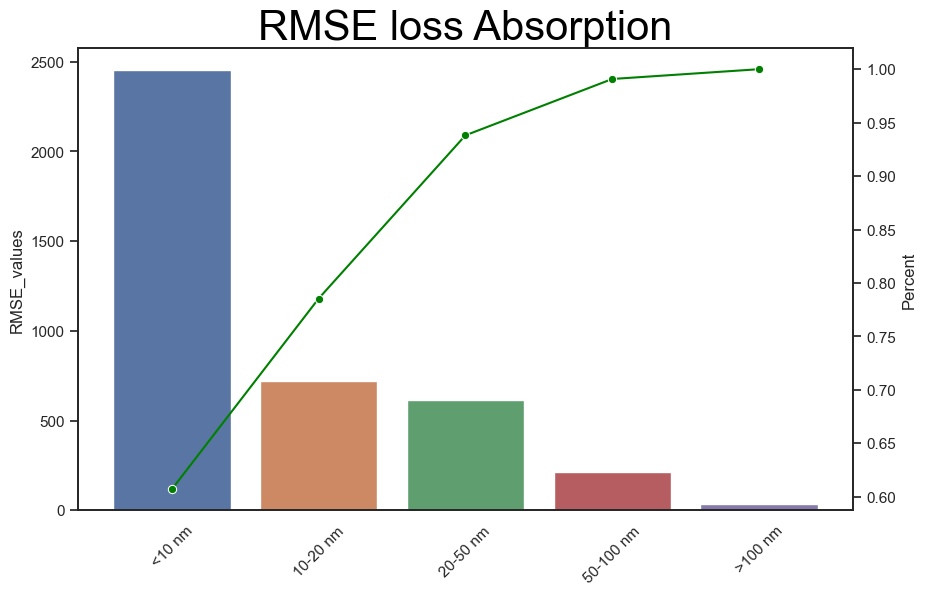

In [38]:
from tqdm import tqdm
import seaborn as sns
index = x_test_abs.index
error_list = []
for i in tqdm(index):
    y_pred = model.predict(np.array(x_test_abs.loc()[i]).reshape(1,-1))
    temp_mse = np.sqrt((np.exp(list(y_test_abs)[i]) - np.exp(y_pred))**2)
    error_list.append(float(temp_mse))
list_10 = len([i for i in error_list if i<10])
list_20 = len([i for i in error_list if 10<i<20])
list_50 = len([i for i in error_list if 20<i<50])
list_60 = len([i for i in error_list if 50<i<100])
list_100 = len([i for i in error_list if i>100])
sns.set_theme(style='white')
data = ['<10 nm','10-20 nm','20-50 nm','50-100 nm','>100 nm']
plt.figure(figsize=(2*5, 2*3))
ax = sns.barplot(x=list(data), y=[list_10,list_20,list_50,list_60,list_100]) 
plt.title('RMSE loss Absorption', fontsize=30,
          color="black")
plt.ylabel('RMSE_values')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax2 = ax.twinx()
ax2 = sns.lineplot(x=data, y=[list_10/len(y_test_abs),(list_10+list_20)/len(y_test_abs),(list_10+list_20+list_50)/len(y_test_abs),(list_10+list_20+list_50+list_60)/len(y_test_abs),(list_10+list_20+list_50+list_60+list_100)/len(y_test_abs)], color='green', marker='o')
ax2.set_ylabel('Percent')
#if you want to download picture uncomment
#plt.savefig('C:\\Python1\\Project\\Graphics\cat_RMSE_dist_for_Absorption_CM.png',
#              dpi=300,
#              bbox_inches='tight')

## Correlation Absorption

In [49]:
from scipy import stats
import plotly.graph_objects as go
сat_reg_model_pred = model.predict(x_test_abs)
slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(сat_reg_model_pred, y_test_abs)
line_test = slope_test * сat_reg_model_pred + intercept_test

cat_reg_error_plot = go.Figure()

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=line_test,\
                                       mode='lines', line_width=5, marker_color='green',\
                                        marker_symbol='triangle-down',
                                       name='Test set trend line: R\u00B2 = ' + str(round(r_value_test**2, 2))))



cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=y_test_abs,\
                                       mode='markers', marker_size=4.5, marker_color='blue', \
                                        marker_symbol='circle-open-dot',
                                       name='Test set prediction'))

cat_reg_error_plot.update_layout(
    width = 1000,
    height=600,
    title_text='XGBoost Regressor values: Absorption',
    xaxis_title="Predicted values",
    yaxis_title="Actual values",
    font=dict(
        family="Ubuntu",
        size=14,
        color="Black"
    )
)

cat_reg_error_plot.update_layout(
    legend=dict(
        title = 'Absorption',
        title_font_family="Ubuntu",
        font=dict(
            family="Ubuntu",
            size=14,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    )
)
cat_reg_error_plot.show()

## SHAP Absorption

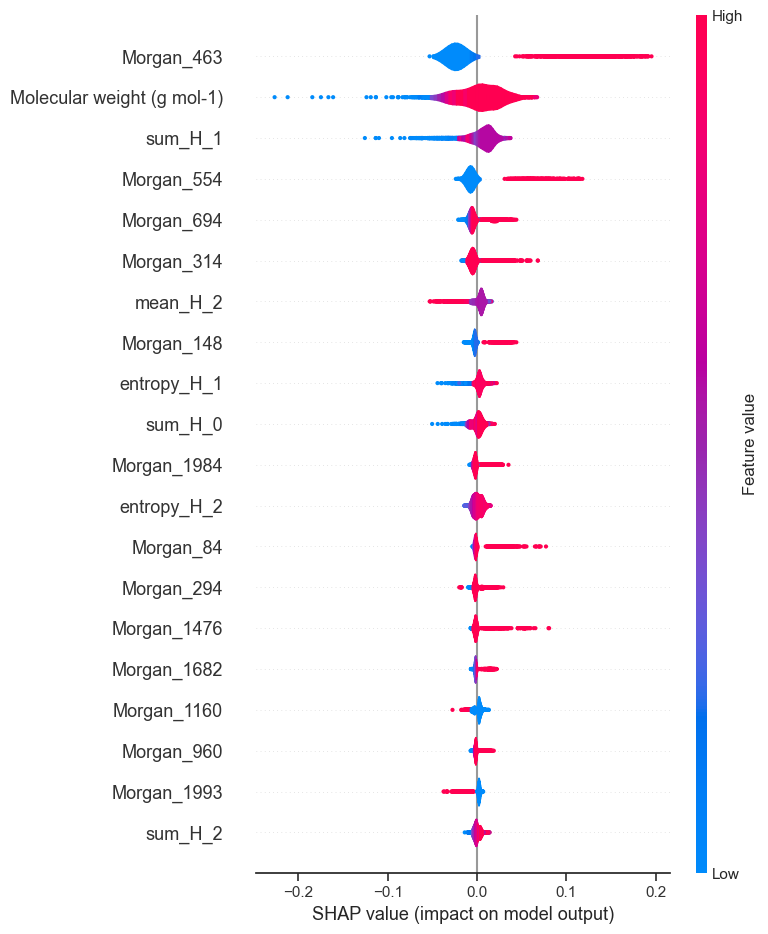

In [43]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_abs)
x_test_abs_1 = pd.DataFrame(np.array(x_test_abs),columns = cm_col)
shap.summary_plot(shap_values, x_test_abs_1, plot_type="violin")

# Optuna Emission

In [51]:
CM_small_morgan_tda_db_em = pd.concat([CM_small, morgan_org, tda_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()

In [52]:
from sklearn.preprocessing import StandardScaler
x_train_em, x_test_em, y_train_em, y_test_em = train_test_split(CM_small_morgan_tda_db_em.loc[:, CM_small_morgan_tda_db_em.columns != 'Emission'], CM_small_morgan_tda_db_em['Emission'], test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
scaler.fit(x_train_em)
y_train_em = np.log(y_train_em)
y_test_em = np.log(y_test_em)
x_train_em = pd.DataFrame(scaler.transform(x_train_em))
x_test_em = pd.DataFrame(scaler.transform(x_test_em))
print('Scalling finished')

Scalling finished


In [55]:
cm_col = CM_small_morgan_tda_db_em.drop(['Emission'],axis=1).columns
cm_col

Index(['CM_0', 'CM_1', 'CM_2', 'CM_3', 'CM_4', 'CM_5', 'CM_6', 'CM_7', 'CM_8',
       'CM_9',
       ...
       'solv_mean_H_0', 'solv_mean_H_1', 'solv_mean_H_2', 'solv_std_H_0',
       'solv_std_H_1', 'solv_std_H_2', 'solv_entropy_H_0', 'solv_entropy_H_1',
       'solv_entropy_H_2', 'Molecular weight (g mol-1)'],
      dtype='object', length=4321)

In [ ]:
#get parametrs for xgboost
import optuna
from optuna.samplers import RandomSampler

#
def objective(trial):
    param = {
 # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014, 0.016,0.020]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    model = xgboost.XGBRegressor(
        **param,
        n_jobs=-1,
        tree_method='gpu_hist', # if you run in colab use tree_method='hist', device = 'cuda'
        missing = np.inf
    )
    model.fit(x_train_em, y_train_em)
    y_pred = model.predict(x_test_em)
    return mean_squared_error(np.exp(y_test_em), np.exp(y_pred))



study_xgb_em = optuna.create_study(
    study_name="xgb_em", direction="minimize", sampler=RandomSampler(42)
)
study_xgb_abs.optimize(objective, n_trials=30)
print("Number of finished trials: ", len(study_xgb_em.trials))
print("Best trial:")
trial_xgb_em = study_xgb_em.best_trial
print("  Value: ", trial_xgb_em.value)
print("  Params: ")
for key, value in trial_xgb_em.params.items():
    print("    {}: {}".format(key, value))

In [53]:
import xgboost
model_em = xgboost.XGBRegressor(**{'lambda': 0.01240590033104614,
                                    'alpha': 0.0016807456139662953,
                                    'colsample_bytree': 0.5,
                                    'subsample': 0.7,
                                    'learning_rate': 0.02,
                                    'max_depth': 13,
                                    'random_state': 42,
                                    'min_child_weight': 9},
                                    n_estimators = 10000,
                                    n_jobs=-1,
                                    tree_method='gpu_hist',  # if you run in colab use tree_method='hist', device = 'cuda' 
                                )
model_em.fit(x_train_em, y_train_em)
y_pred = model_em.predict(x_test_em)

In [54]:
print(f'MRE : {mean_absolute_percentage_error(np.exp(y_test_em), np.exp(y_pred))}')
print(f'MAE : {mean_absolute_error(np.exp(y_test_em), np.exp(y_pred))}')
print(f'RMSE: {mean_squared_error(np.exp(y_test_em), np.exp(y_pred), squared=False)}')
correlation, _ = stats.pearsonr(y_test_em, y_pred)
print(f'Pearson correlation : {correlation}')

MRE : 0.04004224382021733
MAE : 19.855077197002913
RMSE: 30.889547590630837
Pearson correlation : 0.9361465849211371


## Error distribution Emission

100%|██████████| 4043/4043 [00:40<00:00, 99.95it/s] 


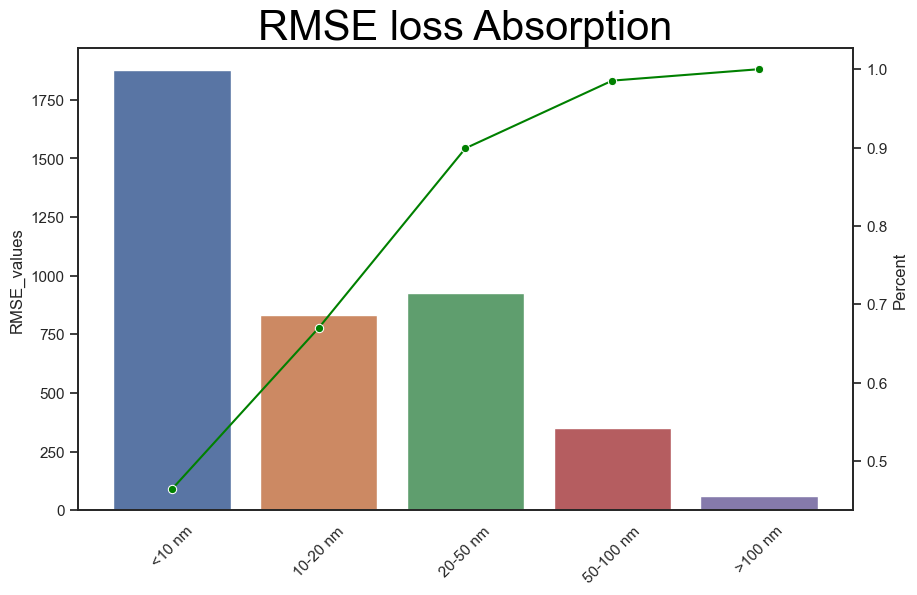

In [57]:
from tqdm import tqdm
import seaborn as sns
index = x_test_em.index
error_list = []
for i in tqdm(index):
    y_pred = model_em.predict(np.array(x_test_em.loc()[i]).reshape(1,-1))
    temp_mse = np.sqrt((np.exp(list(y_test_em)[i]) - np.exp(y_pred))**2)
    error_list.append(float(temp_mse))
list_10 = len([i for i in error_list if i<10])
list_20 = len([i for i in error_list if 10<i<20])
list_50 = len([i for i in error_list if 20<i<50])
list_60 = len([i for i in error_list if 50<i<100])
list_100 = len([i for i in error_list if i>100])
sns.set_theme(style='white')
data = ['<10 nm','10-20 nm','20-50 nm','50-100 nm','>100 nm']
plt.figure(figsize=(2*5, 2*3))
ax = sns.barplot(x=list(data), y=[list_10,list_20,list_50,list_60,list_100])
plt.title('RMSE loss Absorption', fontsize=30,
          color="black")
plt.ylabel('RMSE_values')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax2 = ax.twinx()
ax2 = sns.lineplot(x=data, y=[list_10/len(y_test_em),(list_10+list_20)/len(y_test_em),(list_10+list_20+list_50)/len(y_test_em),(list_10+list_20+list_50+list_60)/len(y_test_em),(list_10+list_20+list_50+list_60+list_100)/len(y_test_em)], color='green', marker='o')
ax2.set_ylabel('Percent')
plt.savefig('C:\Python1\Project\error_dist\error_dist_cat_RMSE_dist_for_Emission_CM.png',
              dpi=300,
              bbox_inches='tight')

## Correlation Emission

In [58]:
from scipy import stats
import plotly.graph_objects as go
сat_reg_model_pred = model_em.predict(x_test_em)
slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(сat_reg_model_pred, y_test_em)
line_test = slope_test * сat_reg_model_pred + intercept_test

cat_reg_error_plot = go.Figure()

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=line_test,\
                                       mode='lines', line_width=5, marker_color='green',\
                                        marker_symbol='triangle-down',
                                       name='Test set trend line: R\u00B2 = ' + str(round(r_value_test**2, 2))))



cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=y_test_em,\
                                       mode='markers', marker_size=4.5, marker_color='blue', \
                                        marker_symbol='circle-open-dot',
                                       name='Test set prediction'))

cat_reg_error_plot.update_layout(
    width = 1000,
    height=600,
    title_text='XGBoost Regressor values: Emission',
    xaxis_title="Predicted values",
    yaxis_title="Actual values",
    font=dict(
        family="Ubuntu",
        size=14,
        color="Black"
    )
)

cat_reg_error_plot.update_layout(
    legend=dict(
        title = 'Emission',
        title_font_family="Ubuntu",
        font=dict(
            family="Ubuntu",
            size=14,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    )
)
cat_reg_error_plot.show()

## SHAP Emission

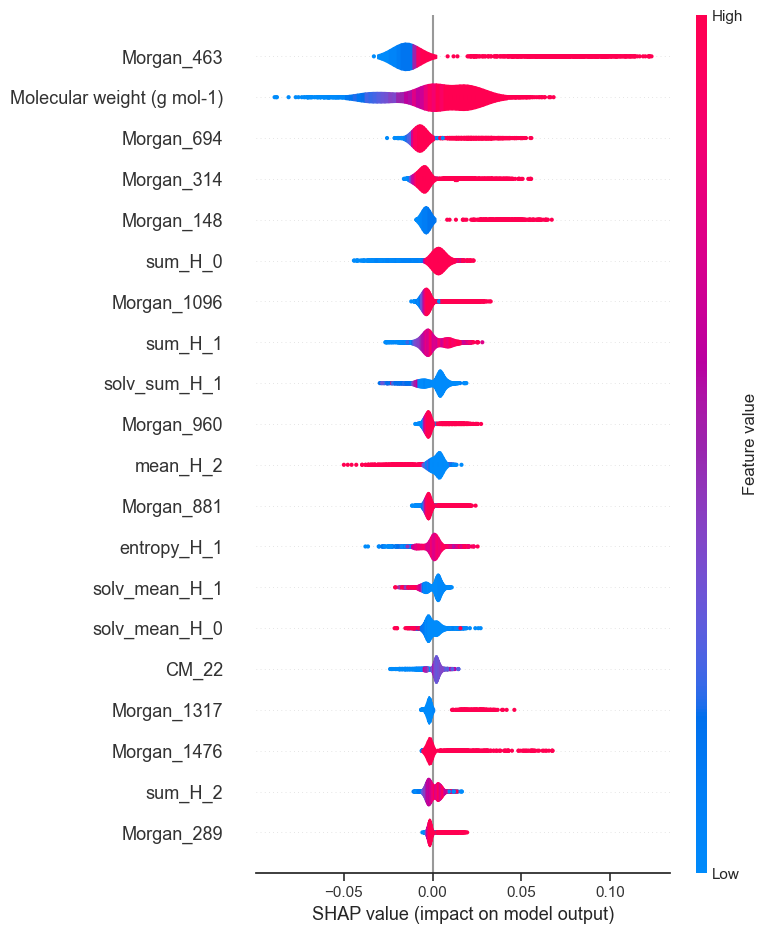

In [59]:
import shap
explainer = shap.TreeExplainer(model_em)
shap_values = explainer.shap_values(x_test_em)
x_test_em_1 = pd.DataFrame(np.array(x_test_em),columns = cm_col)
shap.summary_plot(shap_values, x_test_em_1, plot_type="violin")

# Optuna Quantum yield

In [61]:
CM_small_morgan_tda_db_y = pd.concat([CM_small, morgan_org, tda_full, pd.DataFrame({'Quantum':change_y}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()

In [63]:
from sklearn.preprocessing import StandardScaler
x_train_y, x_test_y, y_train_y, y_test_y = train_test_split(CM_small_morgan_tda_db_y.loc[:, CM_small_morgan_tda_db_y.columns != 'Quantum'], CM_small_morgan_tda_db_y['Quantum'], test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
scaler.fit(x_train_y)
#y_train_y = np.log(y_train_y) 
#y_test_y = np.log(y_test_y) # not log because have zero target value 
x_train_y = pd.DataFrame(scaler.transform(x_train_y))
x_test_y = pd.DataFrame(scaler.transform(x_test_y))
print('Scalling finished')

Scalling finished


In [70]:
cm_col = CM_small_morgan_tda_db_y.drop(['Quantum'],axis=1).columns
cm_col

Index(['CM_0', 'CM_1', 'CM_2', 'CM_3', 'CM_4', 'CM_5', 'CM_6', 'CM_7', 'CM_8',
       'CM_9',
       ...
       'solv_mean_H_0', 'solv_mean_H_1', 'solv_mean_H_2', 'solv_std_H_0',
       'solv_std_H_1', 'solv_std_H_2', 'solv_entropy_H_0', 'solv_entropy_H_1',
       'solv_entropy_H_2', 'Molecular weight (g mol-1)'],
      dtype='object', length=4321)

In [ ]:
import optuna
from optuna.samplers import RandomSampler

def objective(trial):
    model = catboost.CatBoostRegressor(
        iterations=trial.suggest_int("iterations", 2000, 15000),
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-0),
        depth=trial.suggest_int("depth", 4, 15),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-10, 100.0),
        min_child_samples = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-10, 100.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=True,
        random_state=42
                                    )
    model.fit(x_train_y, y_train_y)
    y_pred = model.predict(x_test_y)
    return mean_squared_error((y_test_y), (y_pred))
    "\n",

study_cat_y = optuna.create_study(
    study_name="cat_y", direction="minimize", sampler=RandomSampler(42)",
                                )
study_cat_y.optimize(objective, n_trials=18)
print("Number of finished trials: ", len(study_cat_y.trials))\
print("Best trial:")
trial_cat_y = study_cat_y.best_trial
print("  Value: ", trial_cat_y.value)
print("  Params: ")
for key, value in trial_cat_y.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
model_y = catboost.CatBoostRegressor(iterations=14814, learning_rate=0.24206285095878532, depth=12, l2_leaf_reg=76.1619615328956, min_child_samples=4, bootstrap_type='Bayesian',
                                    random_strength=53.57746840752227, bagging_temperature=0.902897700544083, od_type='IncToDec', od_wait=17,  random_seed=42)
model_y.fit(x_train_y, y_train_y)
y_pred = model_y.predict(x_test_y)

In [68]:
print(f'MRE : {mean_absolute_percentage_error(np.exp(y_test_y), np.exp(y_pred))}')
print(f'MAE : {mean_absolute_error(np.exp(y_test_y), np.exp(y_pred))}')
print(f'RMSE: {mean_squared_error(np.exp(y_test_y), np.exp(y_pred), squared=False)}')
correlation, _ = stats.pearsonr(y_test_y, y_pred)
print(f'Pearson correlation : {correlation}')

MRE : 0.11425227781415986
MAE : 0.17200616809367233
RMSE: 0.2648144212622386
Pearson correlation : 0.7691647286423786


## Error Distributon Quantum Yield

100%|██████████| 4040/4040 [02:01<00:00, 33.29it/s]


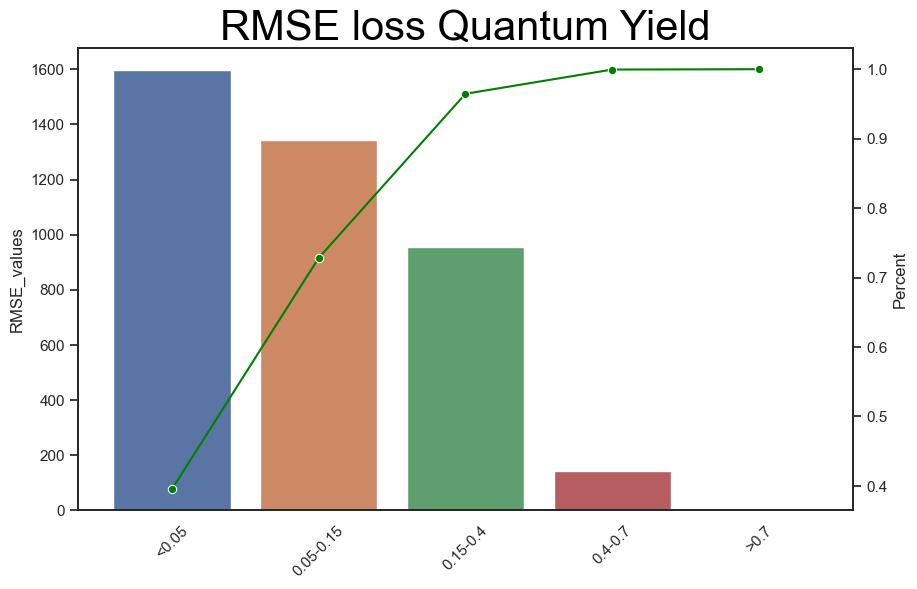

In [65]:
from tqdm import tqdm
import seaborn as sns
index = x_test_y.index
error_list = []
for i in tqdm(index):
    y_pred = model_y.predict(np.array(x_test_y.loc()[i]).reshape(1,-1))
    temp_mse = np.sqrt((list(y_test_y)[i] - y_pred)**2)
    error_list.append(float(temp_mse))

list_10 = len([i for i in error_list if i<0.05])
list_20 = len([i for i in error_list if 0.05<i<0.15])
list_50 = len([i for i in error_list if 0.15<i<0.4])
list_60 = len([i for i in error_list if 0.4<i<0.7])
list_100 = len([i for i in error_list if i>0.7])

sns.set_theme(style='white')
data = ['<0.05','0.05-0.15','0.15-0.4','0.4-0.7','>0.7']
plt.figure(figsize=(2*5, 2*3))
ax = sns.barplot(x=list(data), y=[list_10,list_20,list_50,list_60,list_100]) 
plt.title('RMSE loss Quantum Yield', fontsize=30,
          color="black")
plt.ylabel('RMSE_values')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax2 = ax.twinx()
ax2 = sns.lineplot(x=data, y=[list_10/len(y_test_y),(list_10+list_20)/len(y_test_y),(list_10+list_20+list_50)/len(y_test_y),(list_10+list_20+list_50+list_60)/len(y_test_y),(list_10+list_20+list_50+list_60+list_100)/len(y_test_y)], color='green', marker='o')
ax2.set_ylabel('Percent')
plt.savefig('C:\\Python1\\Project\\error_dist\cat_RMSE_dist_for_yield_CM.png',
               dpi=300,
               bbox_inches='tight')

## Correlation Quantum yield

In [66]:
from scipy import stats
import plotly.graph_objects as go
сat_reg_model_pred = model_y.predict(x_test_y)
slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(сat_reg_model_pred, y_test_y)
line_test = slope_test * сat_reg_model_pred + intercept_test

cat_reg_error_plot = go.Figure()

cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=line_test,\
                                       mode='lines', line_width=5, marker_color='green',\
                                        marker_symbol='triangle-down',
                                       name='Test set trend line: R\u00B2 = ' + str(round(r_value_test**2, 2))))



cat_reg_error_plot.add_trace(go.Scatter(x=сat_reg_model_pred, y=y_test_y,\
                                       mode='markers', marker_size=4.5, marker_color='blue', \
                                        marker_symbol='circle-open-dot',
                                       name='Test set prediction'))

cat_reg_error_plot.update_layout(
    width = 1000,
    height=600,
    title_text='CatBoost Regressor values: Quantum Yield',
    xaxis_title="Predicted values",
    yaxis_title="Actual values",
    font=dict(
        family="Ubuntu",
        size=14,
        color="Black"
    )
)

cat_reg_error_plot.update_layout(
    legend=dict(
        title = 'Quantum Yield',
        title_font_family="Ubuntu",
        font=dict(
            family="Ubuntu",
            size=14,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    )
)
cat_reg_error_plot.show()

## Shap Quantum Yield

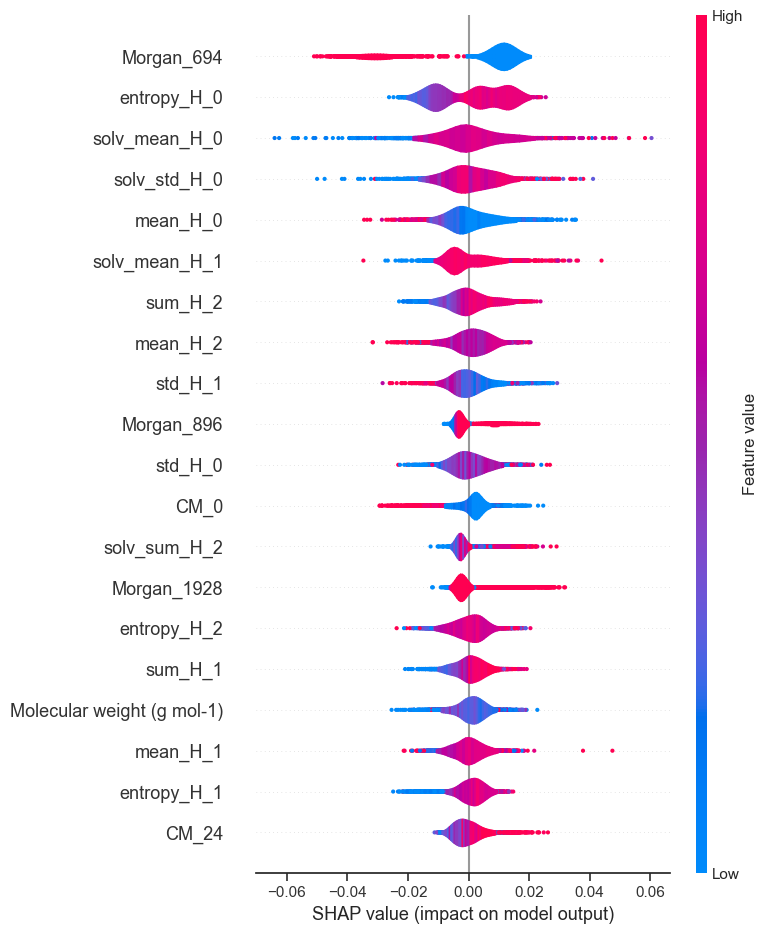

In [71]:
import shap
explainer = shap.TreeExplainer(model_y)
shap_values = explainer.shap_values(x_test_y)
x_test_y_1 = pd.DataFrame(np.array(x_test_y),columns = cm_col)
shap.summary_plot(shap_values, x_test_y_1, plot_type="violin")